In [23]:
from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier
import regularizer_losts as rl
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
import utils as CFI_utils
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

import seaborn as sns
colors = sns.color_palette("tab10")

#Logging stuffs
import logging
import sys
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]


#configs
epochs = 3
batch_size = 60000
test_batch_size = 10000
use_cuda = True
lr = 1
log_interval = 100


#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Agenda
### Big question: CFI for NN


Are we doing complete verification or fuzzing/testing?

What is a `CFI`?

# What is a good abstraction for a NN's structure? Can it be enforced through regularization?
- Distillation? (https://arxiv.org/pdf/1503.02531.pdf)
- Decision Tree? (https://arxiv.org/pdf/1711.09784.pdf)
- Model Extraction? (https://arxiv.org/pdf/2003.04884.pdf)


## Decision Tree
- Is Decision Tree good enough for MNIST? Yes! (https://www.kaggle.com/carlolepelaars/97-on-mnist-with-a-single-decision-tree-t-sne)
- How many paths are there in the decision trees? Need to do experiment
- Is it possible to extract a decision tree from a Neural Network? Seemingly yes (very old paper though https://www.sciencedirect.com/science/article/abs/pii/S0031320398001812)
- From a Tree to a DAG. Maybe just a hunch, but a DAG is more likely to be better for enforcing a CFI. Luckily, it is a realy thing http://www.nowozin.net/sebastian/papers/shotton2013jungles.pdf . Initial results show 30x less nodes for the same accuracy on MNIST
- Action plan:
    - Learn a DAG for MNIST
    - Check how many paths are there
    - If yes, can we apply a CFI mechanism 
    - If a CFI mechanism is applicable, can we convert an arbitrary neural network to a DAG?



In [26]:
#init stuffs
LOAD = True
# LOADPATH = 'TinyCNNreg.conv1.conv2.fc1.fc2.17:09:00'
LOADPATH = 'TinyCNNreg.conv2.fc1.fc2.15:09:24'
# LOADPATH = 'TinyCNNreg.fc1.fc2.16:06:26'


dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
model = TinyCNN().to(device)
if LOAD:
    model.load_state_dict(torch.load(LOADPATH))

In [27]:
#check
#how many unique paths are there in the test set?
layers = ['fc1','fc2']
tensor_log = CFI_utils.test(model, device, test_loader, trace= True, detach=True)
tensor_log_flatten = np.concatenate([tensor_log[l] for l in layers], axis = 1)
test_unique_aps_set = set()
for ap in tensor_log_flatten:
    test_unique_aps_set.add(tuple(ap))

test_unique_aps = np.unique(tensor_log_flatten, axis=0)
print(test_unique_aps.shape, len(test_unique_aps_set))

#how many unique paths are there in the train set?
train_tensor_log = CFI_utils.test(model, device, train_loader, trace= True, detach=True)
train_tensor_log_flatten = np.concatenate([train_tensor_log[l] for l in layers], axis = 1)
train_unique_aps_set = set()
for ap in train_tensor_log_flatten:
    train_unique_aps_set.add(tuple(ap))


train_unique_aps = np.unique(train_tensor_log_flatten, axis=0)
print(train_unique_aps.shape, len(train_unique_aps_set))

#how many parts in the intersection?
intersect = set.intersection(test_unique_aps_set, train_unique_aps_set)
print(len(intersect))


(500, 26) 500
(908, 26) 908
454


# RQ5: With a regularized network, can a adv exp has similar AP?
## Result: As of right now, When the number of AP is small (due to look at only the last few layers), adv exp has very close AP (cannot be distinguished from the real AP)

## Kinda disappointed

128
torch.Size([1, 28, 28])
torch.Size([128, 1, 28, 28])
Epsilon: 0.5	Test Accuracy = 0 / 1 = 0.0
7
vs closest: 523
vs adv: 487


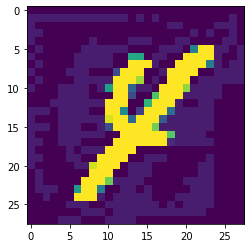

In [8]:
#sample an image, its closest neighbor, and an adv exp
while True:
    victim, closest, d = CFI_utils.sample_pair(train_loader)
    acc, ex = CFI_utils.gen_adv(model, device, [(victim.unsqueeze(0), model(victim.unsqueeze(0).to(device)).argmax().unsqueeze(0))], 0.5)
    if len(ex)>0: break
#plot for checking
plt.figure(); plt.imshow(ex[0][2])
print(ex[0][1])
adv_exp = ex[0][2]

#diff the activation patterns
layers = ['conv2','fc1','fc2']

victim_pattern = CFI_utils.get_pattern(model, device, victim.unsqueeze(0))
closest_pattern = CFI_utils.get_pattern(model, device, closest.unsqueeze(0))
adv_pattern = CFI_utils.get_pattern(model, device, torch.Tensor(adv_exp).unsqueeze(0).unsqueeze(0))

victim_pattern_flatten = np.concatenate([victim_pattern[l] for l in layers], axis=1)
closest_pattern_flatten = np.concatenate([closest_pattern[l] for l in layers], axis = 1)
adv_pattern_flatten = np.concatenate([adv_pattern[l] for l in layers], axis=1)

print("vs closest:", CFI_utils.bit_diff(victim_pattern_flatten, closest_pattern_flatten))
print("vs adv:", CFI_utils.bit_diff(victim_pattern_flatten, adv_pattern_flatten))
